### Train model

In [5]:
# Import libraries.
using Flux, Plots, Random, PlotThemes, Statistics, BayesLaplace
theme(:wong)
# Number of points to generate.
xs, y = toy_data_non_linear(200)
X = hcat(xs...); # bring into tabular format
data = zip(xs,y);

# Neural network:
n_hidden = 32
D = size(X)[1]
nn = Chain(
    Dense(D, n_hidden, σ),
    Dense(n_hidden, 1)
)  
λ = 0.01
sqnorm(x) = sum(abs2, x)
weight_regularization(λ=λ) = 1/2 * λ^2 * sum(sqnorm, Flux.params(nn))
loss(x, y) = Flux.Losses.logitbinarycrossentropy(nn(x), y) + weight_regularization()

# Training:
using Flux.Optimise: update!, ADAM
opt = ADAM()
epochs = 200
for epoch = 1:epochs
  for d in data
    gs = gradient(params(nn)) do
      l = loss(d...)
    end
    update!(opt, params(nn), gs)
  end
end

### Chart

In [6]:
Random.seed!(123)
shuffled_indices = randperm(200)
data = zip(xs[shuffled_indices], y[shuffled_indices]);

In [13]:
xlim = (minimum(X[1,:]),maximum(X[1,:]))
ylim = (minimum(X[2,:]),maximum(X[2,:]))
anim = Animation()
for N in 1:1:length(data)
    la = laplace(nn, λ=λ, subset_of_weights=:last_layer)
    fit!(la, Iterators.take(data,N))
    X = reduce(vcat,map(d -> reshape(d[1],1,length(d[1])),Iterators.take(data, N)))
    y = map(d -> d[2],Iterators.take(data, N))
    plt = plot_contour(X,y,la;xlim=xlim,ylim=ylim,zoom=-2,clegend=false)
    plt = plot(plt, axis=nothing,background_color=:transparent, size=(500,500))
    frame(anim, plt)
end

┌ Info: Saved animation to 
│   fn = /Users/FA31DU/Documents/code/blog/posts/effortsless-bayesian-dl/www/intro.gif
└ @ Plots /Users/FA31DU/.julia/packages/Plots/Zuo5g/src/animation.jl:114


Plots.AnimatedGif("/Users/FA31DU/Documents/code/blog/posts/effortsless-bayesian-dl/www/intro.gif")
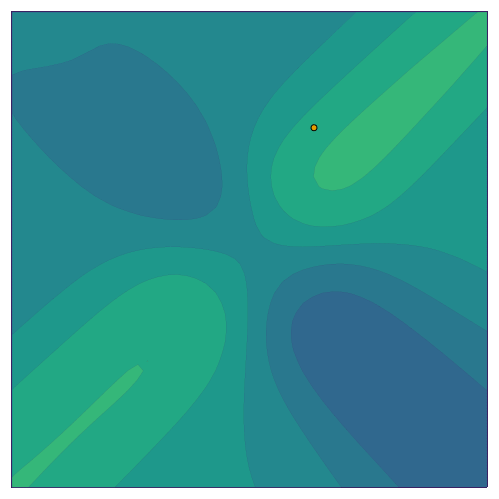

In [14]:
gif(anim, "www/intro.gif", fps=50)